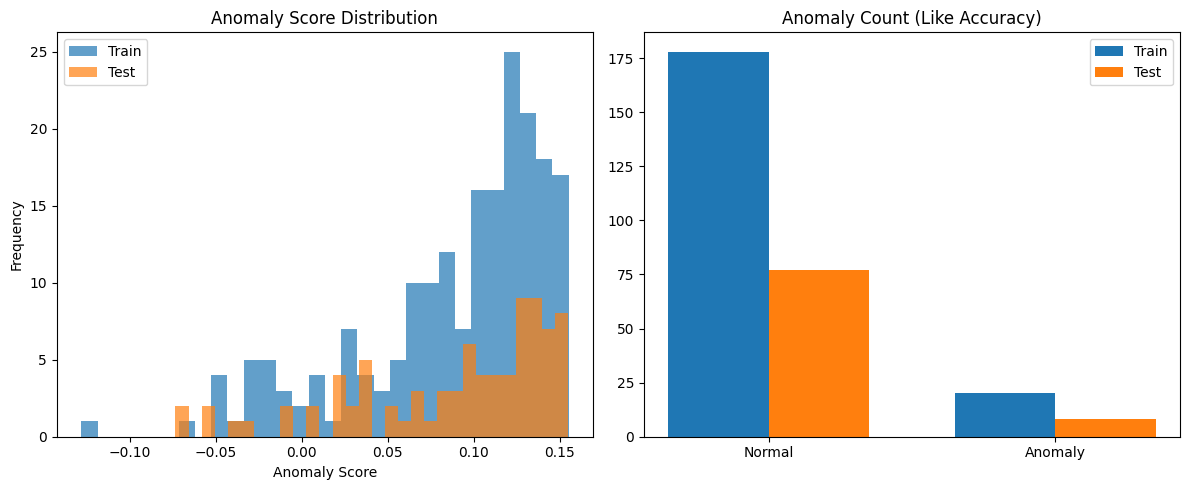

📊 Train Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.95      0.86       148
     Anomaly       0.60      0.24      0.34        50

    accuracy                           0.77       198
   macro avg       0.69      0.59      0.60       198
weighted avg       0.74      0.77      0.73       198

📊 Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.94        68
     Anomaly       1.00      0.47      0.64        17

    accuracy                           0.89        85
   macro avg       0.94      0.74      0.79        85
weighted avg       0.91      0.89      0.88        85


✅ Accuracy:  0.89
✅ Precision: 1.00
✅ Recall:    0.47
✅ F1 Score:  0.64


In [ ]:
# 📌 STEP 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# 📌 STEP 2: Load SSH.csv (Upload first in Colab UI)
df = pd.read_csv("SSH.csv")

# 📌 STEP 3: Feature engineering
# Simulate IP numeric
np.random.seed(42)
df['ip_numeric'] = np.random.randint(1_000_000, 2_000_000, size=len(df))

# Simulate geo_distance (in km)
df['geo_distance'] = np.random.uniform(0, 5000, size=len(df))

# Extract hour from Unix timestamp (if exists), otherwise simulate
if 'ts' in df.columns:
    df['hour'] = pd.to_datetime(df['ts'], unit='s').dt.hour
else:
    df['hour'] = np.random.randint(0, 24, size=len(df))  # fallback

# 📌 STEP 4: Select features for anomaly detection
features = ['hour', 'ip_numeric', 'geo_distance', 'ip_failure', 'td', 'not_valid_count']
X = df[features]

# 📌 STEP 5: Split dataset
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# 📌 STEP 6: Train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X_train)

# 📌 STEP 7: Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_train = np.where(y_pred_train == -1, 1, 0)  # 1 = Anomaly
y_pred_test = np.where(y_pred_test == -1, 1, 0)

# 📌 STEP 8: Get anomaly scores
train_scores = model.decision_function(X_train)
test_scores = model.decision_function(X_test)

# 📌 STEP 9: Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Anomaly Score Histogram
ax[0].hist(train_scores, bins=30, alpha=0.7, label='Train')
ax[0].hist(test_scores, bins=30, alpha=0.7, label='Test')
ax[0].set_title("Anomaly Score Distribution")
ax[0].set_xlabel("Anomaly Score")
ax[0].set_ylabel("Frequency")
ax[0].legend()

# Anomaly Count Bar Chart
labels = ['Normal', 'Anomaly']
train_counts = [np.sum(y_pred_train == 0), np.sum(y_pred_train == 1)]
test_counts = [np.sum(y_pred_test == 0), np.sum(y_pred_test == 1)]

x = np.arange(len(labels))
width = 0.35
ax[1].bar(x - width/2, train_counts, width, label='Train')
ax[1].bar(x + width/2, test_counts, width, label='Test')
ax[1].set_title("Anomaly Count (Like Accuracy)")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 📌 STEP 10: Evaluate performance (only if ground truth exists)
if 'class' in df.columns:
    y_true_train = df.loc[X_train.index, 'class']
    y_true_test = df.loc[X_test.index, 'class']

    print("📊 Train Set Classification Report:")
    print(classification_report(y_true_train, y_pred_train, target_names=["Normal", "Anomaly"]))

    print("📊 Test Set Classification Report:")
    print(classification_report(y_true_test, y_pred_test, target_names=["Normal", "Anomaly"]))

    # Individual metrics
    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)

    print(f"\n✅ Accuracy:  {acc:.2f}")
    print(f"✅ Precision: {prec:.2f}")
    print(f"✅ Recall:    {rec:.2f}")
    print(f"✅ F1 Score:  {f1:.2f}")
else:
    print("⚠️ 'class' column not found — skipping evaluation metrics.")
